In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

def get_preprocessed_stock(ticker: str, start="2020-01-01", end=None):
    """
    下載並清理股票資料，輸出統一格式：
    ['Date', 'Close', 'High', 'Low', 'Open', 'Volume',
     'date_weekday', 'netChangeRatio', 'positive', 'ATR14', 'ATR21']
    """
    # 1️⃣ 下載資料
    df = yf.download(ticker, start=start, end=end, group_by='ticker', auto_adjust=False)

    # 若為 MultiIndex（多層欄位，例如 ('TSLA','Close')）
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(0)

    # 保留主要欄位並重設索引
    df = df[['Close', 'High', 'Low', 'Open', 'Volume']].dropna().copy()
    df = df.reset_index()

    # 2️⃣ 日期資訊
    df['date_weekday'] = df['Date'].dt.weekday  # 0=Mon, ..., 6=Sun

    # 3️⃣ 計算漲跌幅（netChangeRatio）
    df['preClose'] = df['Close'].shift(1)
    df['netChangeRatio'] = (df['Close'] - df['preClose']) / df['preClose'] * 100

    # 4️⃣ 是否上漲（1=漲，0=跌或持平）
    df['positive'] = (df['netChangeRatio'] > 0).astype(int)

    # 5️⃣ 計算 ATR14 / ATR21
    # True Range (TR)：最大值於 [High-Low, |High-preClose|, |Low-preClose|]
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['preClose']).abs()
    low_close = (df['Low'] - df['preClose']).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    df['ATR14'] = tr.rolling(window=14).mean()
    df['ATR21'] = tr.rolling(window=21).mean()

    # 6️⃣ 整理欄位順序
    df = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume',
             'date_weekday', 'netChangeRatio', 'positive', 'ATR14', 'ATR21']]

    # 第一筆 NaN 改為 0，方便模型或分析使用
    df = df.fillna(0)

    return df


# 🔍 範例：抓取 Tesla (TSLA)
tsla_df = get_preprocessed_stock("TSLA", start="2015-01-01", end="2016-12-31")
print(tsla_df.tail(2))

kl_pd = tsla_df.copy()

[*********************100%***********************]  1 of 1 completed

Price       Date   Close       High        Low       Open    Volume  \
502   2016-12-29  14.312  14.613333  14.274667  14.570667  60675000   
503   2016-12-30  14.246  14.500000  14.112000  14.420000  69639000   

Price  date_weekday  netChangeRatio  positive     ATR14     ATR21  
502               3       -2.302717         0  0.361952  0.372159  
503               4       -0.461151         0  0.375238  0.376698  


In [2]:
kl_pd

Price,Date,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive,ATR14,ATR21
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000,4,0.000000,0,0.000000,0.000000
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,0,-4.204103,0,0.000000,0.000000
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,1,0.566424,1,0.000000,0.000000
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,2,-0.156193,0,0.000000,0.000000
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,3,-0.156431,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
499,2016-12-23,14.222667,14.230000,13.847333,13.866667,70057500,4,2.345888,1,0.338143,0.356286
500,2016-12-27,14.635333,14.816667,14.294667,14.325333,88735500,1,2.901469,1,0.360952,0.371556
501,2016-12-28,14.649333,14.920000,14.480000,14.768667,56737500,2,0.095658,1,0.352381,0.377270
502,2016-12-29,14.312000,14.613333,14.274667,14.570667,60675000,3,-2.302717,0,0.361952,0.372159


In [3]:
# 追蹤趨勢
# N1：價格大於最近 42 天的最高價，作為買入訊號
# N2：價格小於最近 21 天的最低價，作為賣出訊號

N1 = 42
N2 = 21

# 取得滑動視窗大小為 N1 的滾動最大值
kl_pd['n1_high'] = kl_pd['High'].rolling(window=N1).max()
print(kl_pd[['High', 'n1_high']].head(3))

# 填充因為滾動視窗不足而產生的 NaN
expan_max = kl_pd['Close'].expanding().max()
kl_pd['n1_high'] = kl_pd['n1_high'].fillna(expan_max)
print(kl_pd[['High', 'n1_high']].head(3))

kl_pd

Price       High  n1_high
0      14.883333      NaN
1      14.433333      NaN
2      14.280000      NaN
Price       High    n1_high
0      14.883333  14.620667
1      14.433333  14.620667
2      14.280000  14.620667


Price,Date,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive,ATR14,ATR21,n1_high
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000,4,0.000000,0,0.000000,0.000000,14.620667
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,0,-4.204103,0,0.000000,0.000000,14.620667
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,1,0.566424,1,0.000000,0.000000,14.620667
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,2,-0.156193,0,0.000000,0.000000,14.620667
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,3,-0.156431,0,0.000000,0.000000,14.620667
...,...,...,...,...,...,...,...,...,...,...,...,...
499,2016-12-23,14.222667,14.230000,13.847333,13.866667,70057500,4,2.345888,1,0.338143,0.356286,14.246667
500,2016-12-27,14.635333,14.816667,14.294667,14.325333,88735500,1,2.901469,1,0.360952,0.371556,14.816667
501,2016-12-28,14.649333,14.920000,14.480000,14.768667,56737500,2,0.095658,1,0.352381,0.377270,14.920000
502,2016-12-29,14.312000,14.613333,14.274667,14.570667,60675000,3,-2.302717,0,0.361952,0.372159,14.920000


In [4]:
# 計算最近 N2 天最低价
kl_pd['n2_low'] = kl_pd['Low'].rolling(window=N2).min()

# expanding_min：从第一天到现在不断取最小值
expan_min = kl_pd['Close'].expanding().min()

# 用 expanding_min 补 rolling 的开头 NaN
kl_pd['n2_low'] = kl_pd['n2_low'].fillna(expan_min)

kl_pd

Price,Date,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive,ATR14,ATR21,n1_high,n2_low
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000,4,0.000000,0,0.000000,0.000000,14.620667,14.620667
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,0,-4.204103,0,0.000000,0.000000,14.620667,14.006000
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,1,0.566424,1,0.000000,0.000000,14.620667,14.006000
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,2,-0.156193,0,0.000000,0.000000,14.620667,14.006000
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,3,-0.156431,0,0.000000,0.000000,14.620667,14.006000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2016-12-23,14.222667,14.230000,13.847333,13.866667,70057500,4,2.345888,1,0.338143,0.356286,14.246667,12.000000
500,2016-12-27,14.635333,14.816667,14.294667,14.325333,88735500,1,2.901469,1,0.360952,0.371556,14.816667,12.000000
501,2016-12-28,14.649333,14.920000,14.480000,14.768667,56737500,2,0.095658,1,0.352381,0.377270,14.920000,12.000000
502,2016-12-29,14.312000,14.613333,14.274667,14.570667,60675000,3,-2.302717,0,0.361952,0.372159,14.920000,12.000000


<Axes: ylabel='count'>

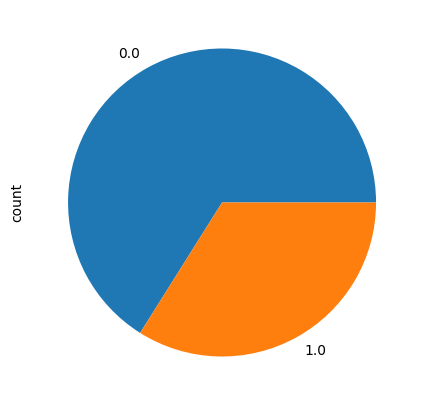

In [5]:
# 建立買入訊號(1)與賣出訊號(0)
# 建立 signal 欄位
kl_pd['signal'] = np.nan

# 🔼 買入訊號：收盤價突破前 N1 天最高價
buy_index = kl_pd[kl_pd['Close'] > kl_pd['n1_high'].shift(1)].index
kl_pd.loc[buy_index, 'signal'] = 1

# 🔽 賣出訊號：收盤價跌破前 N2 天最低價
sell_index = kl_pd[kl_pd['Close'] < kl_pd['n2_low'].shift(1)].index
kl_pd.loc[sell_index, 'signal'] = 0

# 看一下買入跟賣出訊號的圓餅圖
kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))


基準報酬率：-2.60%
策略報酬率：4.57%


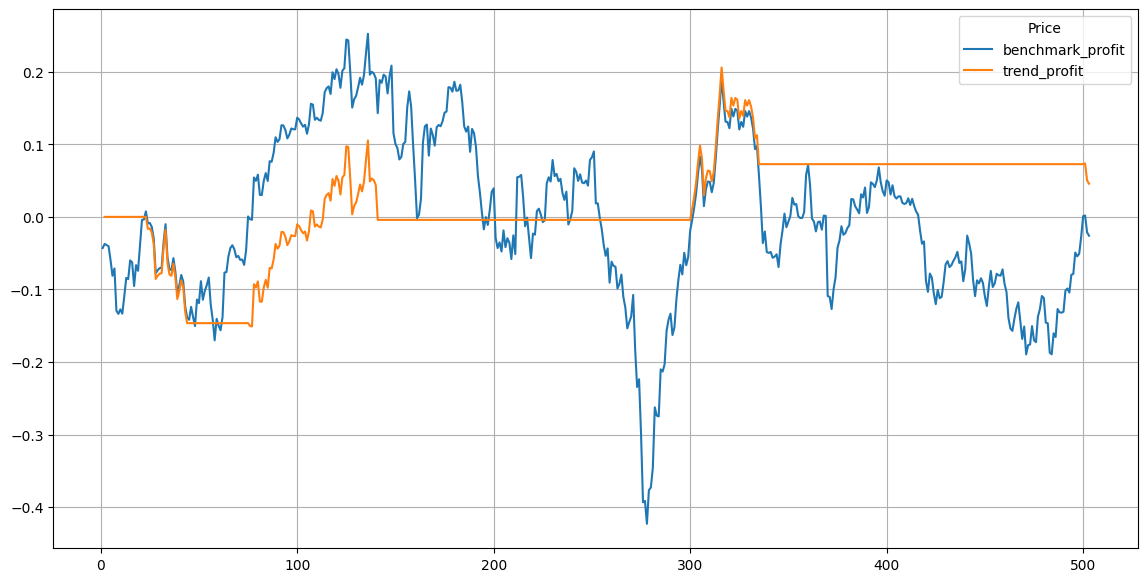

In [6]:
# === 產生買入/賣出訊號 ===

# 當天收盤價突破最近 N1 天最高價 → 買入訊號 (signal = 1)
buy_index = kl_pd[kl_pd['Close'] > kl_pd['n1_high'].shift(1)].index
kl_pd.loc[buy_index, 'signal'] = 1

# 當天收盤價跌破最近 N2 天最低價 → 賣出訊號 (signal = 0)
sell_index = kl_pd[kl_pd['Close'] < kl_pd['n2_low'].shift(1)].index
kl_pd.loc[sell_index, 'signal'] = 0


# === 依據 signal 生成隔日的持股狀態 keep ===
# shift(1) 表示：訊號隔一天才動作（收盤後才知道突破）
kl_pd['keep'] = kl_pd['signal'].shift(1)

# 將 NaN 往前填滿（第一次訊號以前的狀態）
kl_pd['keep'] = kl_pd['keep'].ffill()


# === 計算基準報酬率（對數報酬）===
kl_pd['benchmark_profit'] = np.log(
    kl_pd['Close'] / kl_pd['Close'].shift(1)
)


# === 計算策略報酬率 ===
# 若 keep=1 → 持倉，獲得當天市場漲跌
# 若 keep=0 → 空倉，報酬為 0
kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']


# === 畫出累積報酬比較 ===
kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(
    grid=True, figsize=(14, 7)
)

# 比較基準跟策略的總報酬率：
print(f"基準報酬率：{kl_pd['benchmark_profit'].sum():.2%}")
print(f"策略報酬率：{kl_pd['trend_profit'].sum():.2%}")

